In [1]:
import os,sys,inspect
import numpy as np
import matplotlib.pyplot as plt

import torch

torch.set_default_dtype(torch.float32)

import ehtim as eh # eht imaging package

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from generative_model import glow_model
from generative_model import realnvpfc_model
from DPI_interferometry import Img_logscale

Welcome to eht-imaging! v  0.1.2


# Load the learned DPI normalizing flow for VLBI

In [2]:
# load obs file
obs_path = '../../dataset/interferometry1/obs.uvfits'
obs = eh.obsdata.load_uvfits(obs_path)
flux_const = np.median(obs.unpack_bl('APEX', 'ALMA', 'amp')['amp'])

# define the normalizing flow network
device = torch.device("cpu")#torch.device("cuda" if torch.cuda.is_available() else "cpu")
npix = 32
n_flow = 16
affine = True
img_generator = realnvpfc_model.RealNVP(npix*npix, n_flow, affine=affine).to(device)
logscale_factor = Img_logscale(scale=flux_const/(0.8*npix*npix)).to(device)

generator_file = '../checkpoint/interferometry/generativemodel_realnvp_res32flow16logdet1.0_closure_fluxcentermemtsv'
logscale_file = '../checkpoint/interferometry/generativescale_realnvp_res32flow16logdet1.0_closure_fluxcentermemtsv'
img_generator.load_state_dict(torch.load(generator_file, map_location=device))
logscale_factor.load_state_dict(torch.load(logscale_file, map_location=device))
# img_generator.eval()
# logscale_factor.eval()

Loading uvfits:  ../../dataset/interferometry1/obs.uvfits
Number of uvfits Correlation Products: 4
No NX table in uvfits!


/home/groot/anaconda3/envs/torch_proj/lib/python3.7/site-packages/ehtim/obsdata.py:486: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(datalist)


<All keys matched successfully>

# Generate and plot image samples

In [3]:
# generate image samples
n_sample = 1024#32#128#
z_sample = torch.randn(n_sample, npix*npix).to(device=device)

# generate image samples
img_samp, logdet = img_generator.reverse(z_sample)
img_samp = img_samp.reshape((-1, npix, npix))

# apply scale factor and sigmoid/softplus layer for positivity constraint
logscale_factor_value = logscale_factor.forward()
scale_factor = torch.exp(logscale_factor_value)
img = torch.nn.Softplus()(img_samp) * scale_factor
image = img.detach().cpu().numpy()

(<Figure size 1080x1080 with 1 Axes>,
 Text(0.5, 1.0, 'DPI generated VLBI image samples'))

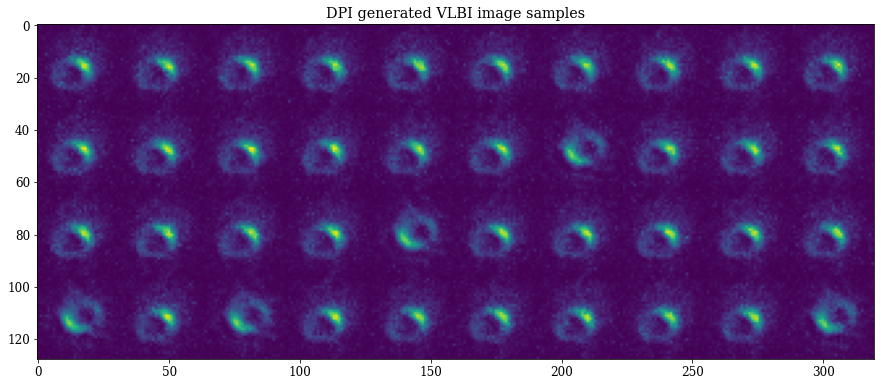

In [4]:
image_stitch = np.zeros((npix*4, npix*10))
for k in range(40):
    i = k//10
    j = k%10
    image_stitch[npix*i:npix*(i+1), npix*j:npix*(j+1)] = image[k]
plt.figure(figsize = (15,15)), plt.imshow(image_stitch), plt.title('DPI generated VLBI image samples')

# Characterize multiple modes of image samples using t-SNE plot

Text(0, 0.5, 't-SNE Dimension #2')

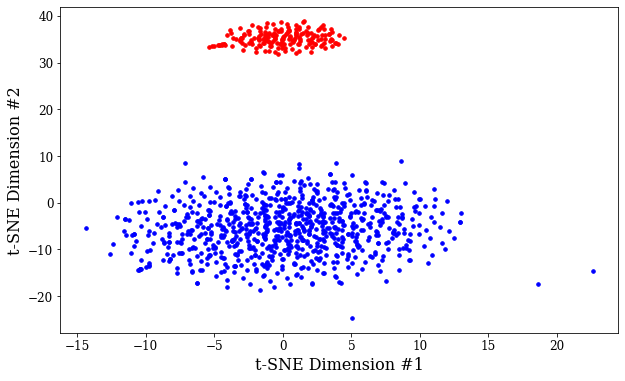

In [5]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
X = image.reshape((-1, npix*npix))
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_embedded = tsne.fit_transform(X)

x = X_embedded[:, 0]
y = X_embedded[:, 1]

kmeans = KMeans(n_clusters=2, random_state=0).fit(X_embedded)

plt.figure(figsize=(10, 6)), plt.scatter(x[kmeans.labels_==0], y[kmeans.labels_==0], c='blue', marker='.', s=50)
plt.scatter(x[kmeans.labels_==1], y[kmeans.labels_==1], c='red', marker='.', s=50)
plt.xlabel('t-SNE Dimension #1', fontsize=16)
plt.ylabel('t-SNE Dimension #2', fontsize=16)

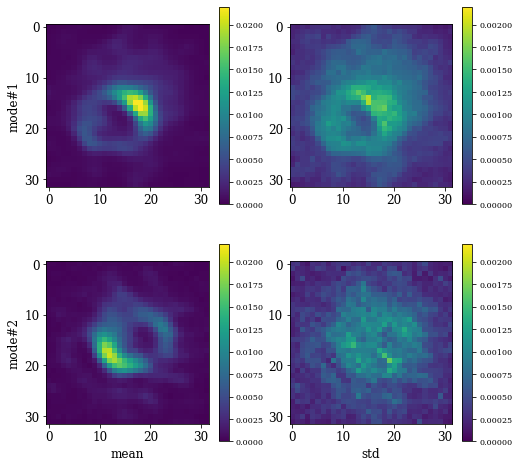

In [6]:
# plot mean and std of each mode
img_mean1 = np.mean(image[kmeans.labels_==0], 0)
img_std1 = np.std(image[kmeans.labels_==0], 0)
img_mean2 = np.mean(image[kmeans.labels_==1], 0)
img_std2 = np.std(image[kmeans.labels_==1], 0)


fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# plot mode#1
im = axs[0, 0].imshow(img_mean1, vmin=0, vmax=2.2e-2)
axs[0, 0].set(ylabel='mode#1', xlabel='')
cbar = fig.colorbar(im, ax=axs[0, 0])
cbar.ax.tick_params(labelsize=8)

im = axs[0, 1].imshow(img_std1, vmin=0, vmax=2.2e-3)
axs[0, 1].set(ylabel=' ', xlabel='')
cbar = fig.colorbar(im, ax=axs[0, 1])
cbar.ax.tick_params(labelsize=8)

# plot mode#2
im = axs[1, 0].imshow(img_mean2, vmin=0, vmax=2.2e-2)
axs[1, 0].set(ylabel='mode#2', xlabel='mean')
cbar = fig.colorbar(im, ax=axs[1, 0])
cbar.ax.tick_params(labelsize=8)

im = axs[1, 1].imshow(img_std2, vmin=0, vmax=2.2e-3)
axs[1, 1].set(ylabel='', xlabel='std')
cbar = fig.colorbar(im, ax=axs[1, 1])
cbar.ax.tick_params(labelsize=8)

for ax in axs.flat:
    ax.label_outer()